In [2]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_rows = 9999

In [ ]:
''' 오픈 소스 데이터에 누락된 값이 너무 많음 -> 새로 생성 후 계산  '''
# 파일 읽기 (탭 구분 txt → csv처럼 읽음)
dist_matrix = pd.read_csv(
    "E:/glass_git/AI-portfolio/order_batch_picking/data/Distance matrix/DistanceMatrix_36SubAisles.txt",
    sep="\t")

# null인 컬럼 삭제
cols_with_nulls = [col for col in dist_matrix.columns if dist_matrix[col].isnull().any()]
print(cols_with_nulls)
dist_matrix.drop(columns=cols_with_nulls,inplace=True)


#index 값인 0 컬럼을 기준으로 row 중복 제거
dist_matrix.drop_duplicates(subset=["0"], keep="first",inplace=True)
dist_matrix.index=dist_matrix['0']
dist_matrix.drop(columns=['0'],inplace=True)

# 중복 컬럼 삭제
cols_with_dot = dist_matrix.filter(regex=r'^\d+\.\d+$').columns.tolist()
print(cols_with_dot)
dist_matrix.drop(columns=cols_with_dot,inplace=True)

# dist_matrix.to_csv('E:/glass_git/AI-portfolio/order_batch_picking/data/Distance matrix/dist_matrix.csv',index=True)

In [18]:
''' 
창고 레이아웃 설계
Rack : [1,24]
Bay : [1,120]
Tier= 0
Slot = [1,2880]

Aisle 간격 = 50
Rack 길이 = 1200
Bay 길이 = 10

시작 위치 = (30,30)

'''
start=30

max_bay_num   = 120
rack_width = 5
aisle_interval = 50   
bay_length     = 10   

rack_num=list(range(1,25))
bay_num=list(range(1,121))

rack_bay_slot=[]
slot_num=1

for rack in rack_num:
    for bay in bay_num:
        for i in range(1,2):
            rack_bay_slot.append([rack,bay,slot_num])
            slot_num+=1
matrix=pd.DataFrame(rack_bay_slot,columns=['rack','bay','slot'])
matrix['aisle']=matrix['rack'].apply(lambda x: math.ceil(x/2))
matrix=matrix[['aisle','rack','bay','slot']]


#aisle별로 rack이 홀수면 aisle*50, 짝수면 홀수값+50, 다음 aisle 홀수 rack 이전값+rack 넓이, 짝수면 이전 홀수값+50
aisle_range=list(range(1,13))

X=[]
for aisle in aisle_range:
    for rack in rack_num:
        mat=matrix[(matrix['aisle']==aisle)&(matrix['rack']==rack)]
        if (aisle==1)&(rack==1):
            X+=[start]*len(mat)
        elif (aisle==1)&(rack==2):
            X+=[X[-1]+aisle_interval]*len(mat)
        else:
            if (rack%2)!=0:
                X+=[X[-1]+rack_width]*len(mat)
            else:
                X+=[X[-1]+aisle_interval]*len(mat)

Y=[]
for aisle in aisle_range:
    for rack in rack_num:
        for bay in bay_num:
            mat=matrix[(matrix['aisle']==aisle)&(matrix['rack']==rack)&(matrix['bay']==bay)]
            if bay==1:
                y_coord=start
            else:
                y_coord=start+((bay-1)*bay_length)
            Y+=[y_coord]*len(mat)

matrix['x']=X
matrix['y']=Y

#시작점
matrix.loc[2880]=[0,0,0,0,0,0]

In [19]:
matrix.sort_values(by=['slot'],inplace=True)
matrix.reset_index(inplace=True,drop=True)
matrix.head()

,aisle,rack,bay,slot,x,y
0,0,0,0,0,0,0
1,1,1,1,1,30,30
2,1,1,2,2,30,40
3,1,1,3,3,30,50
4,1,1,4,4,30,60


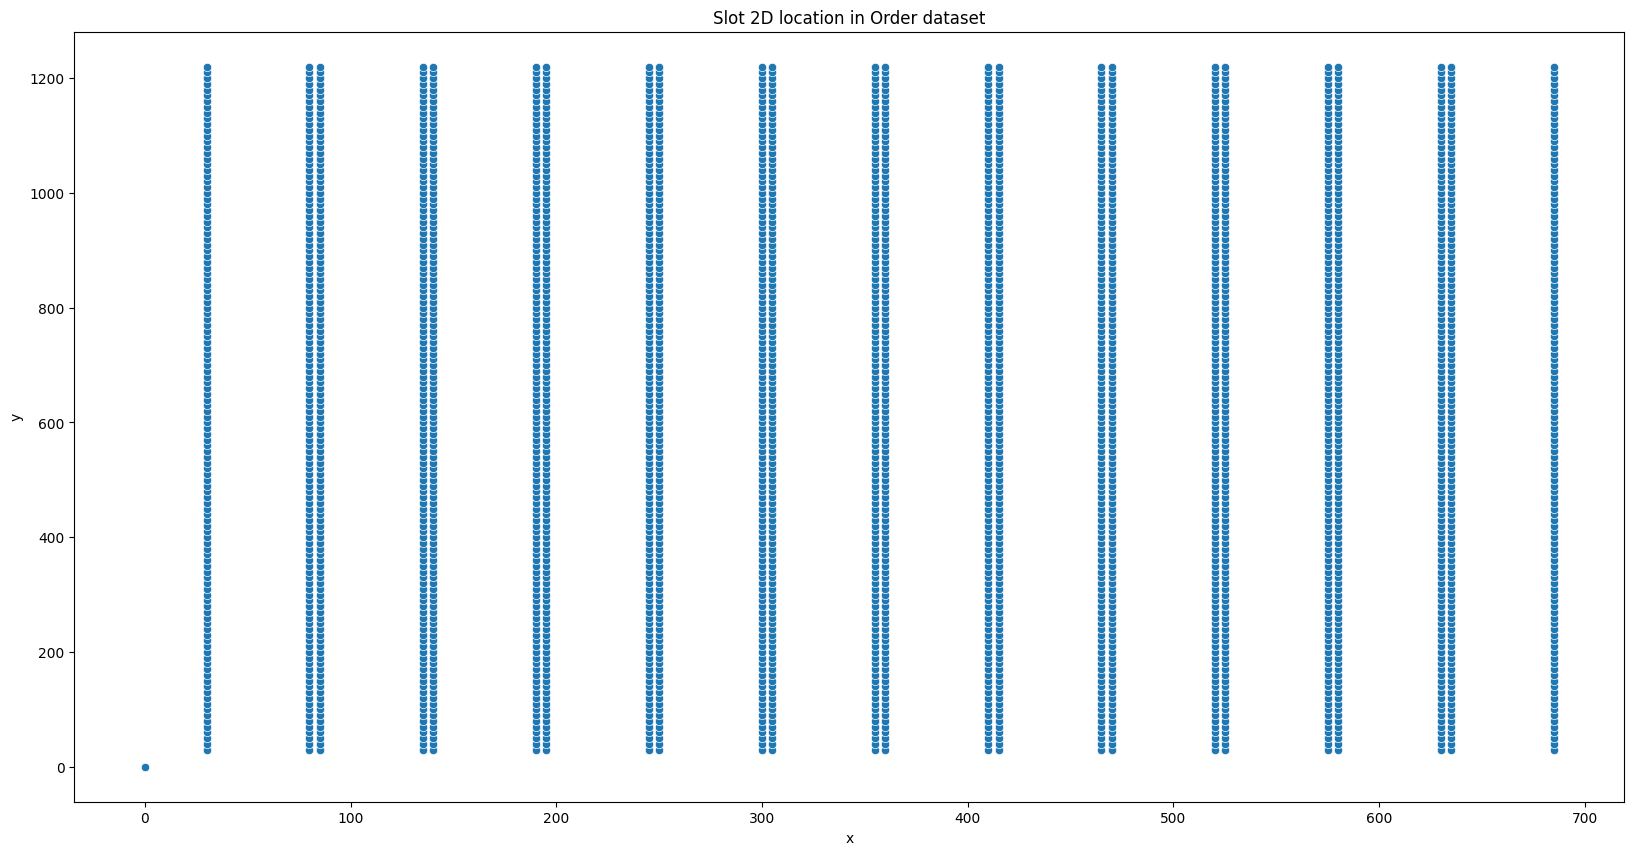

In [20]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=matrix,x='x',y='y')
plt.title('Slot 2D location in Order dataset')
plt.show()
plt.close()


In [ ]:
#pandas로 matrix 만들기 -> 속도가 너무 느림

max_bay_num=120
max_rack_num=24

total_dist=0
aisle_interval=50 #통로 너비
rack_length=1200 #rack 전체 길이
bay_length=10 #bay 세로 길이

def dist_stright(start, end):
    _,rack_s,bay_s=start
    _,rack_e,bay_e=end
    dist=abs(rack_s-rack_e)*aisle_interval+abs(bay_s-bay_e)*bay_length
    return dist

def dist_tail(start, end):
    aisle_s,rack_s,bay_s=start
    aisle_e,rack_e,bay_e=end
    #current_sate에서 tail로 이동
    move_tail=abs(max_bay_num-bay_s)*bay_length
    move_next_aile=abs(aisle_s-aisle_e)*aisle_interval
    #tail에서 item으로 이동
    move_item=abs(max_bay_num-bay_e)*bay_length
    dist=move_tail+move_next_aile+move_item
    return dist

def dist_head(start, end):
    aisle_s,rack_s,bay_s=start
    aisle_e,rack_e,bay_e=end
    #current_sate에서 head로 이동
    move_head=bay_s*bay_length
    move_next_aile=abs(aisle_s-aisle_e)*aisle_interval
    #head에서 item으로 이동
    move_item=bay_e*bay_length
    dist=move_head+move_next_aile+move_item
    return dist

def sort_slot(slot1,slot2):
    #move_stratage : tail, head, stright
    
    aisle1,rack1,bay1=slot1
    aisle2,rack2,bay2=slot2
   
    if aisle1==aisle2:
        if bay1>bay2:
            start=slot2
            end=slot1
           
        else:
            start=slot1
            end=slot2
        
        move_stratage='stright'
        return start,end,move_stratage
        
    else:
        if rack1>rack2:
            start=slot2
            end=slot1

        else:
            start=slot1
            end=slot2

        if start[2]>math.ceil(max_bay_num/2):
            move_stratage='tail'
        else:
            move_stratage='head'
            
        return start,end,move_stratage


def distance(slot1,slot2):

    start, end, move_stratage=sort_slot(slot1,slot2)
    if (slot1==slot2).all():
       dist=0
    else:
        if move_stratage=='stright':
            dist=dist_stright(start, end)
        elif move_stratage=='head':
            dist=dist_tail(start, end)
        else:
            dist=dist_head(start, end)
        
    return dist

slot_list=matrix.slot.unique()
matrix_=[]
for slot1_num in slot_list:
    row=[]
    for slot2_num in slot_list:
        slot1=matrix[matrix['slot']==slot1_num][['aisle','rack','bay']].values[0]
        slot2=matrix[matrix['slot']==slot2_num][['aisle','rack','bay']].values[0]

        dist=distance(slot1,slot2)
        row.append(dist)
    matrix_.append(row)

pd.DataFrame(matrix_)

In [21]:
#numba로 distance matrix 생성

import numpy as np
import math
from numba import njit, prange

# ====== 상수 (Numba가 읽을 수 있게 전역으로 둠) ======
aisle_length=1220
max_bay_num   = 120
aisle_interval = 50   # 통로 너비
bay_length     = 10   # bay 세로 길이
_mid_bay = (max_bay_num + 1) // 2  # ceil(max_bay_num/2)와 동일

# ====== 거리 함수 (Numba용) ======
@njit
def dist_stright_numba(x1,y1,x2,y2):
    return abs(x1-x2)+abs(y1+y2)

@njit
def dist_tail_numba(sx,sy,ex,ey):
    move_tail = aisle_length-sy
    move_next = abs(ex-sx)
    move_item = aisle_length-ey
    return move_tail + move_next + move_item

@njit
def dist_head_numba(sx,sy,ex,ey):
    move_head = sy
    move_next = abs(ex-sx)
    move_item = ey
    return move_head + move_next + move_item


@njit
def distance_numba(a1, r1, b1,x1,y1, a2,r2,b2,x2,y2):
    # 같은 aisle이면 straight
    if a1 == a2:
        return dist_stright_numba(x1,y1,x2,y2)

    # 다른 aisle이면 rack 작은 쪽을 start로 정렬
    elif a1>a2:
        sa,sr,sb,sx,sy=a2,r2,b2,x2,y2
        ea,er,eb,ex,ey=a1, r1, b1,x1,y1
    else:
        sa,sr,sb,sx,sy=a1, r1, b1,x1,y1
        ea,er,eb,ex,ey=a2,r2,b2,x2,y2

    # head/tail 결정 (시작 bay 기준)
    if sb > _mid_bay:
        return dist_tail_numba(sx,sy,ex,ey)
    else:
        return dist_head_numba(sx,sy,ex,ey)

@njit(parallel=True)
def build_dist_mat(A, R, B, X, Y):
    N = A.shape[0]
    M = np.zeros((N, N), dtype=np.float64)
    for i in prange(N):
        ai, ri, bi, xi, yi = A[i], R[i], B[i], X[i], Y[i]
        M[i, i] = 0.0
        for j in range(i + 1, N):
            d = distance_numba(ai, ri, bi, xi, yi, A[j], R[j], B[j], X[j], Y[j])
            M[i, j] = d
            M[j, i] = d
    return M


slot_order=matrix.slot.unique()
df_coords = (
    matrix.set_index('slot')
          .loc[slot_order, ['aisle', 'rack', 'bay','x','y']]
          .astype(np.int64)
)
coords = df_coords.to_numpy() 
A = coords[:, 0]
R = coords[:, 1]
B = coords[:, 2]
X = coords[:, 3]
Y = coords[:, 4]


dist_mat = build_dist_mat(A, R, B, X, Y)  


In [22]:
dist_mat

array([[   0.,   60.,   70., ..., 1885., 1895., 1905.],
       [  60.,    0.,   70., ..., 1885., 1895., 1905.],
       [  70.,   70.,    0., ..., 1895., 1905., 1915.],
       ...,
       [1885., 1885., 1895., ...,    0., 2410., 2420.],
       [1895., 1895., 1905., ..., 2410.,    0., 2430.],
       [1905., 1905., 1915., ..., 2420., 2430.,    0.]])

In [23]:
dist_df = pd.DataFrame(dist_mat, index=slot_order, columns=slot_order)
dist_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2871,2872,2873,2874,2875,2876,2877,2878,2879,2880
0,0.0,60.0,70.0,80.0,90.0,100.0,110.0,120.0,130.0,140.0,...,1815.0,1825.0,1835.0,1845.0,1855.0,1865.0,1875.0,1885.0,1895.0,1905.0
1,60.0,0.0,70.0,80.0,90.0,100.0,110.0,120.0,130.0,140.0,...,1815.0,1825.0,1835.0,1845.0,1855.0,1865.0,1875.0,1885.0,1895.0,1905.0
2,70.0,70.0,0.0,90.0,100.0,110.0,120.0,130.0,140.0,150.0,...,1825.0,1835.0,1845.0,1855.0,1865.0,1875.0,1885.0,1895.0,1905.0,1915.0
3,80.0,80.0,90.0,0.0,110.0,120.0,130.0,140.0,150.0,160.0,...,1835.0,1845.0,1855.0,1865.0,1875.0,1885.0,1895.0,1905.0,1915.0,1925.0
4,90.0,90.0,100.0,110.0,0.0,130.0,140.0,150.0,160.0,170.0,...,1845.0,1855.0,1865.0,1875.0,1885.0,1895.0,1905.0,1915.0,1925.0,1935.0


In [ ]:
# dist_df.to_pickle('E:/glass_git/AI-portfolio/order_batch_picking/data/Distance matrix/dist_matrix.pkl')

In [26]:
dist_matrix=pd.read_pickle('E:/glass_git/AI-portfolio/order_batch_picking/data/Distance matrix/dist_matrix.pkl')
dist_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,2871,2872,2873,2874,2875,2876,2877,2878,2879,2880
0,0.0,60.0,70.0,80.0,90.0,100.0,110.0,120.0,130.0,140.0,...,1815.0,1825.0,1835.0,1845.0,1855.0,1865.0,1875.0,1885.0,1895.0,1905.0
1,60.0,0.0,70.0,80.0,90.0,100.0,110.0,120.0,130.0,140.0,...,1815.0,1825.0,1835.0,1845.0,1855.0,1865.0,1875.0,1885.0,1895.0,1905.0
2,70.0,70.0,0.0,90.0,100.0,110.0,120.0,130.0,140.0,150.0,...,1825.0,1835.0,1845.0,1855.0,1865.0,1875.0,1885.0,1895.0,1905.0,1915.0
3,80.0,80.0,90.0,0.0,110.0,120.0,130.0,140.0,150.0,160.0,...,1835.0,1845.0,1855.0,1865.0,1875.0,1885.0,1895.0,1905.0,1915.0,1925.0
4,90.0,90.0,100.0,110.0,0.0,130.0,140.0,150.0,160.0,170.0,...,1845.0,1855.0,1865.0,1875.0,1885.0,1895.0,1905.0,1915.0,1925.0,1935.0
